To start using the quantum hardware, we need a free IBM account.
The link to create an IBM account is:
https://quantum-computing.ibm.com/

Click on "Create an IBMid account." and follow the steps.
This can take a few minutes, it is best if you do it before the tutorial.

In this part of the tutorial, we will use Shor's algorithm to find the factors of a number.
In this case, we will choose a relatively small number N=15, otherwise the quantum circuit would become too big.

In [1]:
!pip install qiskit
!pip install qiskit-aer
!pip install numpy

In [4]:
# Importing standard Qiskit libraries
#from qiskit import QuantumCircuit, transpile, assemble
import qiskit
from qiskit_aer import Aer, AerSimulator
from qiskit.visualization import *

%matplotlib inline
import matplotlib.pyplot as plt
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction
import numpy as np

In [5]:
# We need the inverse of the Quantum Fourier Transform

def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

#Alternatively, you can now just import the QFT circuit from qiskit directly.
'''
from qiskit.circuit.library import QFT

Then in a quantum circuit qc, you have to call:
qc.append(QFT(n).inverse(), range(n))

To apply the inverse QFT on n wires.

'''


'\nfrom qiskit.circuit.library import QFT\n\nThen in a quantum circuit qc, you have to call:\nqc.append(QFT(n).inverse(), range(n))\n\nTo apply the inverse QFT on n wires.\n\n'

In [6]:
# For period finding (Shor) and for the subsequent prime factors finding
# we need a gate that can do :
# U|y⟩ = |ay mod 15⟩

def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = QuantumCircuit(4)
    for iteration in range(power):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, power)
    c_U = U.control()
    return c_U

In [7]:
N = 15

# To make sure we get reproducible results, we set the seed of the random number generator
np.random.seed(1)
a = randint(2, 15)

# Let's look at a and make sure it is not already a non-trivial factor of 15
print("The chosen initial a is: ", a)
print("The gcd of a and 15 is: ",gcd(a, N))

# Now we do Shor's order finding algorithm for the initial a value and N = 15
# the phase we measure will be s/r, where: (a^r) mod N = 1
# and s is a random integer between 0 and r−1.

def qpe_amod15(a):
    n_count = 8
    qc = QuantumCircuit(4+n_count, n_count)

    for q in range(n_count):
        qc.h(q)     # Initialize counting qubits in state |+>
        # The counting qubits that are used to control unitary operations
    qc.x(3+n_count) # And auxiliary register in state |1>

    for q in range(n_count): # Do controlled-U operations
        qc.append(c_amod15(a, 2**q),
                 [q] + [i+n_count for i in range(4)])
    qc.append(qft_dagger(n_count), range(n_count)) # Do inverse-QFT
    qc.measure(range(n_count), range(n_count))

    # Simulate Results
    aer_sim = Aer.get_backend('aer_simulator')
    t_qc = transpile(qc, aer_sim)
    result = aer_sim.run(t_qc, memory=True).result() # Setting memory=True below allows us to see a list of each sequential reading
    readings = result.get_memory()

    print("Register Reading: " + readings[0])
    phase = int(readings[0],2)/(2**n_count)

    print("Corresponding Phase: %f" % phase)
    return phase

The chosen initial a is:  7
The gcd of a and 15 is:  1


In [8]:
# Let's combine all functions we defined above and run the Shor algorithm for
# multiple attempts, until we find a non-trivial factor

factor_found = False
attempt = 0
while not factor_found:
    attempt += 1
    print("\nAttempt %i:" % attempt)

    phase = qpe_amod15(a) # Phase = s/r
    frac = Fraction(phase).limit_denominator(N) # Denominator should tell us r (but not always)
    r = frac.denominator

    print("Result: r = %i" % r)
    if phase != 0:

        # Guesses for factors are gcd(x^{r/2} ±1 , 15)
        guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
        print("Guessed Factors: %i and %i" % (guesses[0], guesses[1]))

        for guess in guesses:
            if guess not in [1,N] and (N % guess) == 0: # Check to see if guess is a factor
                print("*** Non-trivial factor found: %i ***" % guess)
                factor_found = True


Attempt 1:
Register Reading: 01000000
Corresponding Phase: 0.250000
Result: r = 4
Guessed Factors: 3 and 5
*** Non-trivial factor found: 3 ***
*** Non-trivial factor found: 5 ***


In [9]:
#Homework: send this now to the hardware. Plot the resulting circuit and plot a histogram how often you find a good result


Attempt 1:
Register Reading: 10000000
Corresponding Phase: 0.500000
Result: r = 2
Guessed Factors: 3 and 1
*** Non-trivial factor found: 3 ***


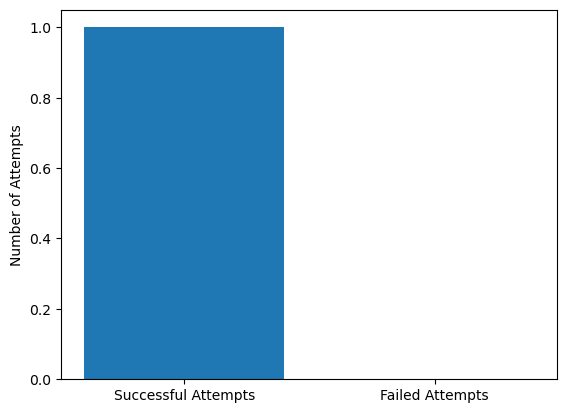

In [10]:
#First we will just adapt the code so that we plot the histogram.

import matplotlib.pyplot as plt

# Initialize counters
total_attempts = 0
successful_attempts = 0

factor_found = False
while not factor_found:
    total_attempts += 1
    print("\nAttempt %i:" % total_attempts)

    phase = qpe_amod15(a) # Phase = s/r
    frac = Fraction(phase).limit_denominator(N) # Denominator should tell us r (but not always)
    r = frac.denominator

    print("Result: r = %i" % r)
    if phase != 0:

        # Guesses for factors are gcd(x^{r//2} ±1 , 15)
        guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
        print("Guessed Factors: %i and %i" % (guesses[0], guesses[1]))

        for guess in guesses:
            if guess not in [1,N] and (N % guess) == 0: # Check if guess is a factor
                print("*** Non-trivial factor found: %i ***" % guess)
                factor_found = True
        successful_attempts += 1

# Calculate failed attempts
failed_attempts = total_attempts - successful_attempts if total_attempts >= successful_attempts else 0

# Plot histogram
plt.bar(['Successful Attempts', 'Failed Attempts'], [successful_attempts, failed_attempts])
plt.ylabel('Number of Attempts')
plt.show()

In [11]:
#Now we adapt to hardware
!pip install qiskit-ibm-runtime

  Using cached requests_ntlm-1.3.0-py3-none-any.whl.metadata (2.4 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 2.3 MB/s eta 0:00:00
  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
  Using cached pyspnego-0.11.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached PyJWT-2.10.1-py3-none-any.whl.metadata (4.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 5.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.2/366.2 kB 7.4 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.8/444.8 kB 5.2 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 8.0 MB/s eta 0:00:00a 0:00:01m
Using cached requests_ntlm-1.3.0-py3-none-any.whl (6.6 kB)
Using cached annotated_types-0.7.0-py3-none-any.whl (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━

In [12]:
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

#Setup service with your IBM token
ibm_quantum_service = QiskitRuntimeService(channel="ibm_quantum", token="your_ibm_token")

#Find the least busy backend
backend = ibm_quantum_service.least_busy(operational=True, simulator=False)
print("Least busy backend:", backend.name)

/var/folders/0y/p40nt1td47xgs3zh4yrj4qwc0000gn/T/ipykernel_26147/4026964111.py:5: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud", "ibm_quantum_platform", and "local" will be the only valid channels. Open Plan users should migrate now.  All other users should review the migration guide (https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp)to learn when to migrate.
  ibm_quantum_service = QiskitRuntimeService(channel="ibm_quantum", token="your_ibm_token")


IBMNotAuthorizedError: '401 Client Error: Unauthorized for url: https://auth.quantum.ibm.com/api/users/loginWithToken. Login failed., Error code: 3446.'

In [13]:
def qpe_amod15(a):
    n_count = 8
    qc = QuantumCircuit(4 + n_count, n_count)

    for q in range(n_count):
        qc.h(q)  # Initialize counting qubits in state |+>
    qc.x(3 + n_count)  # And auxiliary register in state |1>

    for q in range(n_count):  # Do controlled-U operations
        qc.append(c_amod15(a, 2 ** q), [q] + [i + n_count for i in range(4)])
    qc.append(qft_dagger(n_count), range(n_count))  # Do inverse-QFT
    qc.measure(range(n_count), range(n_count))

    # transpile the circuit
    pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
    transpiled_qc = pm.run(qc)

    # simulate Results
    sampler = Sampler(backend=backend)

    job = sampler.run([transpiled_qc], shots=1024)
    print(f"Job ID: {job.job_id()}")

    # get the result from the job
    result = job.result()

    pub_result = result[0]
    data_bin = pub_result.data

    bitarray = data_bin.c
    counts_dict = bitarray.get_counts()

    readings = list(counts_dict.keys())
    print("Register Reading: " + readings[0])

    phase = int(readings[0], 2) / (2 ** n_count)
    print("Corresponding Phase: %f" % phase)
    return phase

In [14]:
total_attempts = 0
successful_attempts = 0

factor_found = False
while not factor_found:
    total_attempts += 1
    print("\nAttempt %i:" % total_attempts)

    phase = qpe_amod15(a)
    frac = Fraction(phase).limit_denominator(N)
    r = frac.denominator

    print("Result: r = %i" % r)
    if phase != 0:

        # Guesses for factors are gcd(x^{r//2} ±1 , 15)
        guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
        print("Guessed Factors: %i and %i" % (guesses[0], guesses[1]))

        for guess in guesses:
            if guess not in [1,N] and (N % guess) == 0:
                print("*** Non-trivial factor found: %i ***" % guess)
                factor_found = True
        successful_attempts += 1

failed_attempts = total_attempts - successful_attempts if total_attempts >= successful_attempts else 0

plt.bar(['Successful Attempts', 'Failed Attempts'], [successful_attempts, failed_attempts])
plt.ylabel('Number of Attempts')
plt.show()


Attempt 1:


NameError: name 'backend' is not defined